<a href="https://colab.research.google.com/github/saurav80325-create/sentiment-analysis/blob/main/sentiment-analysis_multiDatasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q kaggle pandas numpy scikit-learn matplotlib seaborn nltk textblob joblib

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
from google.colab import files
files.upload()  # upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sauravyadav59","key":"17cb14478b9dc7eac3b7c70ede1a1082"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Twitter Airline Sentiment
!kaggle datasets download -d crowdflower/twitter-airline-sentiment -p /content/data/twitter --unzip

# IMDb Movie Reviews
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews -p /content/data/imdb --unzip

# Amazon Product Reviews (Sentiment)
!kaggle datasets download -d datafiniti/consumer-reviews-of-amazon-products -p /content/data/amazon --unzip


Dataset URL: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
License(s): CC-BY-NC-SA-4.0
  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 750MB/s]
Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
  0% 0.00/25.7M [00:00<?, ?B/s]
100% 25.7M/25.7M [00:00<00:00, 1.11GB/s]
Dataset URL: https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products
License(s): CC-BY-NC-SA-4.0
  0% 0.00/16.3M [00:00<?, ?B/s]
100% 16.3M/16.3M [00:00<00:00, 1.18GB/s]


In [6]:
import pandas as pd, numpy as np, re, nltk, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib, os
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = [w for w in text.split() if w not in stop]
    return ' '.join(words)


LR → 0.7893
NB → 0.7244
SVM → 0.7845
Twitter Ensemble Accuracy: 0.7814207650273224


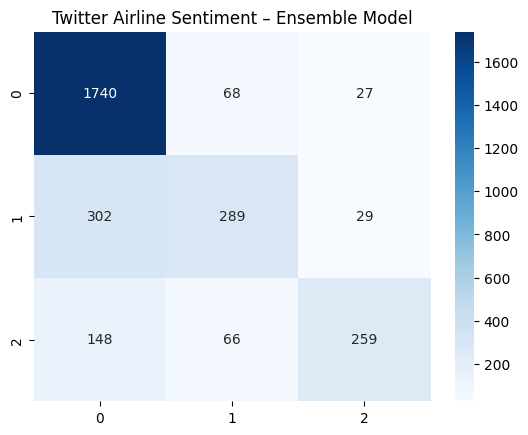

In [8]:
df_twitter = pd.read_csv("/content/data/twitter/Tweets.csv")[['airline_sentiment','text']]
df_twitter.rename(columns={'airline_sentiment':'label','text':'text'}, inplace=True)
df_twitter['clean_text'] = df_twitter['text'].apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(df_twitter['clean_text'], df_twitter['label'],
                                                    test_size=0.2, random_state=42, stratify=df_twitter['label'])
vec_twitter = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_vec = vec_twitter.fit_transform(X_train)
X_test_vec  = vec_twitter.transform(X_test)

models_twitter = {
    'LR': LogisticRegression(max_iter=2000),
    'NB': MultinomialNB(),
    'SVM': LinearSVC()
}
for n,m in models_twitter.items():
    m.fit(X_train_vec, y_train)
    print(f"{n} → {m.score(X_test_vec,y_test):.4f}")

ens_twitter = VotingClassifier(
    estimators=[('lr',models_twitter['LR']),('nb',models_twitter['NB']),('svm',models_twitter['SVM'])],
    voting='hard'
)
ens_twitter.fit(X_train_vec,y_train)
acc_twitter = ens_twitter.score(X_test_vec,y_test)
print("Twitter Ensemble Accuracy:", acc_twitter)

sns.heatmap(confusion_matrix(y_test,ens_twitter.predict(X_test_vec)),annot=True,fmt='d',cmap='Blues')
plt.title("Twitter Airline Sentiment – Ensemble Model")
plt.show()


LR → 0.8962
NB → 0.8661
SVM → 0.8876
IMDb Ensemble Accuracy: 0.8964


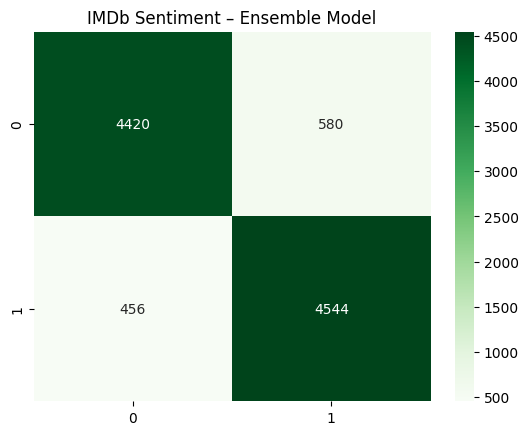

In [9]:
df_imdb = pd.read_csv("/content/data/imdb/IMDB Dataset.csv")
df_imdb['clean_text'] = df_imdb['review'].apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(df_imdb['clean_text'], df_imdb['sentiment'],
                                                    test_size=0.2, random_state=42, stratify=df_imdb['sentiment'])
vec_imdb = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_vec = vec_imdb.fit_transform(X_train)
X_test_vec  = vec_imdb.transform(X_test)

models_imdb = {
    'LR': LogisticRegression(max_iter=2000),
    'NB': MultinomialNB(),
    'SVM': LinearSVC()
}
for n,m in models_imdb.items():
    m.fit(X_train_vec, y_train)
    print(f"{n} → {m.score(X_test_vec,y_test):.4f}")

ens_imdb = VotingClassifier(
    estimators=[('lr',models_imdb['LR']),('nb',models_imdb['NB']),('svm',models_imdb['SVM'])],
    voting='hard'
)
ens_imdb.fit(X_train_vec,y_train)
acc_imdb = ens_imdb.score(X_test_vec,y_test)
print("IMDb Ensemble Accuracy:", acc_imdb)

sns.heatmap(confusion_matrix(y_test,ens_imdb.predict(X_test_vec)),annot=True,fmt='d',cmap='Greens')
plt.title("IMDb Sentiment – Ensemble Model")
plt.show()


Checking files under: /content/data/amazon
 - /content/data/amazon/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv
 - /content/data/amazon/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv
 - /content/data/amazon/1429_1.csv

Candidate files to load (first 10):
 * /content/data/amazon/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv
 * /content/data/amazon/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv
 * /content/data/amazon/1429_1.csv
Trying pd.read_csv on /content/data/amazon/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv

Loaded file: /content/data/amazon/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv  -> shape: (5000, 24)

Columns: ['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand', 'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer', 'manufacturerNumber', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rati

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0,3,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0,5,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-05-27T00:00:00Z,True,NaN,0,4,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...


After flattening, columns: ['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand', 'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer', 'manufacturerNumber', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs']

Auto-detected candidates -> text_col: reviews.date , rating_col: reviews.rating

Minimal df shape: (5000, 2)


,text,rating
0,2017-09-03T00:00:00.000Z,3
1,2017-06-06T00:00:00.000Z,5
2,2018-04-20T00:00:00.000Z,4


After labeling, counts:
 label
positive    4686
negative     117
Name: count, dtype: int64
LR → Test Acc: 0.9761
NB → Test Acc: 0.9761
SVM → Test Acc: 0.9761
Amazon Ensemble Accuracy: 0.9760665972944849
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        23
    positive       0.98      1.00      0.99       938

    accuracy                           0.98       961
   macro avg       0.49      0.50      0.49       961
weighted avg       0.95      0.98      0.96       961



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


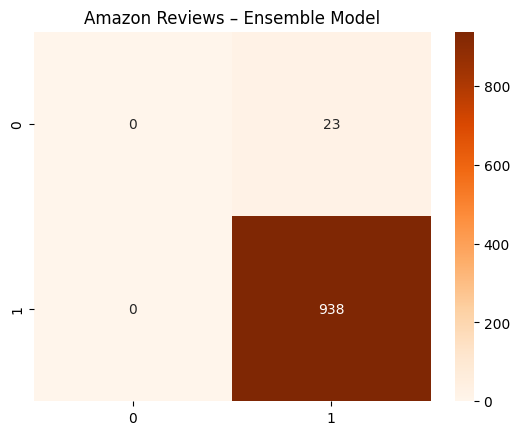

Saved amazon_vectorizer.joblib and amazon_ensemble.joblib to /content/drive/MyDrive/sentiment_triple_project


In [16]:
# ----- Robust loader + trainer for Amazon dataset -----
import os, glob, zipfile, json, ast
import pandas as pd, numpy as np, re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns
import joblib

amazon_dir = '/content/data/amazon'
print("Checking files under:", amazon_dir)
files = []
for root, dirs, filenames in os.walk(amazon_dir):
    for f in filenames:
        files.append(os.path.join(root, f))
if not files:
    print("No files found in /content/data/amazon. Make sure you downloaded/unzipped the Kaggle dataset.")
else:
    for f in files[:50]:  # print up to first 50 files
        print(" -", f)

# If there's a .zip, extract it
zip_files = [f for f in files if f.lower().endswith('.zip')]
if zip_files:
    print("\nFound zip file(s). Extracting first one:", zip_files[0])
    with zipfile.ZipFile(zip_files[0], 'r') as z:
        z.extractall(amazon_dir + '_extracted')
    amazon_dir = amazon_dir + '_extracted'
    # rebuild file list
    files = []
    for root, dirs, filenames in os.walk(amazon_dir):
        for f in filenames:
            files.append(os.path.join(root, f))
    print("After extraction, top files:")
    for f in files[:20]:
        print(" -", f)

# Helper: try loading a file into DataFrame
def try_load_any(path):
    ext = path.lower().split('.')[-1]
    try:
        if ext in ('csv','txt'):
            print("Trying pd.read_csv on", path)
            return pd.read_csv(path)
        if ext in ('json',):
            print("Trying pd.read_json (lines=True) on", path)
            try:
                return pd.read_json(path, lines=True)
            except Exception as e:
                print("pd.read_json(lines=True) failed:", e, "- trying generic read_json")
                return pd.read_json(path)
        if ext in ('gz','bz2'):
            print("Trying pd.read_csv with compression on", path)
            return pd.read_csv(path, compression='infer', error_bad_lines=False)
    except Exception as e:
        print("Failed to read", path, ":", type(e).__name__, e)
    return None

# Try to find a reasonable file to load
candidates = [f for f in files if any(f.lower().endswith(ext) for ext in ['.json','.csv','.txt','.gz','.bz2'])]
if not candidates:
    raise RuntimeError("No JSON/CSV files found in the Amazon folder. Check dataset download.")
print("\nCandidate files to load (first 10):")
for c in candidates[:10]:
    print(" *", c)

# try loading candidates until success
df = None
for c in candidates:
    df_try = try_load_any(c)
    if isinstance(df_try, pd.DataFrame) and not df_try.empty:
        df = df_try
        loaded_path = c
        print("\nLoaded file:", c, " -> shape:", df.shape)
        break

if df is None:
    raise RuntimeError("Could not load any candidate file into a DataFrame. Inspect files manually.")

# Quick inspect
print("\nColumns:", df.columns.tolist()[:60])
display(df.head(3))

# If any column holds dicts/lists, try to normalize them
# This flattens columns where cells are dicts or lists-of-dicts
def flatten_nested(df):
    df2 = df.copy()
    for col in df.columns:
        # detect dict-like entries
        sample = df[col].dropna().head(10)
        if sample.apply(lambda x: isinstance(x, dict)).any():
            print("Normalizing dict column:", col)
            nested = pd.json_normalize(df[col].dropna())
            nested.index = df[col].dropna().index
            df2 = pd.concat([df2.drop(columns=[col]), nested], axis=1)
        # if the column contains strings that look like JSON list/dict, try ast.literal_eval on sample
        elif sample.apply(lambda x: isinstance(x, str) and (x.strip().startswith('{') or x.strip().startswith('['))).any():
            try:
                parsed = sample.apply(ast.literal_eval)
                if parsed.apply(lambda x: isinstance(x, dict)).any() or parsed.apply(lambda x: isinstance(x, list)).any():
                    print("Column appears to contain JSON strings; attempting to parse and normalize:", col)
                    full_parsed = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) and (x.strip().startswith('{') or x.strip().startswith('[')) else x)
                    # if lists of dicts, explode then json_normalize
                    if full_parsed.dropna().apply(lambda x: isinstance(x, list)).any():
                        exploded = full_parsed.explode().dropna().apply(lambda x: x if isinstance(x, dict) else None)
                        exploded = exploded.dropna().apply(pd.Series)
                        # merge back by index (simple heuristic)
                        exploded.index = exploded.index
                        df2 = pd.concat([df2.reset_index(drop=True), exploded.reset_index(drop=True)], axis=1)
                    else:
                        normalized = full_parsed.dropna().apply(pd.Series)
                        normalized.index = full_parsed.dropna().index
                        df2 = pd.concat([df2.drop(columns=[col]), normalized], axis=1)
            except Exception as e:
                pass
    return df2

df = flatten_nested(df)
print("After flattening, columns:", df.columns.tolist()[:60])

# Try to auto-detect text & rating columns by substring matching
cols = df.columns.tolist()
def find_col_by_candidates(candidates):
    for cand in candidates:
        for c in cols:
            if cand.lower() in c.lower():
                return c
    return None

text_col = find_col_by_candidates(['review','reviews.text','reviews_text','reviews_text','text','body','comments','content','reviewText'])
rating_col = find_col_by_candidates(['rating','stars','reviews.rating','score','overall','reviews_rating'])

print("\nAuto-detected candidates -> text_col:", text_col, ", rating_col:", rating_col)

# If still none, show top 20 columns and types to help debugging
if text_col is None or rating_col is None:
    print("\nUnable to auto-detect text or rating columns. Here are the top 20 columns and a sample of values to inspect:")
    for c in cols[:20]:
        print(f" - {c} (dtype={df[c].dtype}) sample:", repr(df[c].dropna().iloc[:3].tolist()[:3]))
    # Try a fallback: if there's a 'reviews.text' like nested column earlier, maybe present as 'reviews'
    if 'reviews' in df.columns:
        print("\nFound column named 'reviews' — will attempt to expand it.")
        try:
            exploded = df['reviews'].explode().dropna().apply(pd.Series)
            df = pd.concat([df.reset_index(drop=True), exploded.reset_index(drop=True)], axis=1)
            cols = df.columns.tolist()
            text_col = text_col or find_col_by_candidates(['review','text'])
            rating_col = rating_col or find_col_by_candidates(['rating','stars'])
            print("After expanding 'reviews', new columns:", df.columns.tolist()[:40])
        except Exception as e:
            print("Couldn't expand 'reviews':", e)

# Final check
if text_col is None or rating_col is None:
    raise RuntimeError("Failed to identify text or rating columns automatically. Inspect the printed column samples above and set text_col and rating_col manually.")

# Build minimal dataframe
df_small = df[[text_col, rating_col]].dropna().rename(columns={text_col:'text', rating_col:'rating'})
print("\nMinimal df shape:", df_small.shape)
display(df_small.head(3))

# Convert rating to numeric if possible
def safe_to_numeric(x):
    try:
        return float(x)
    except:
        return None

if df_small['rating'].dtype == object:
    # try convert
    df_small['rating_num'] = df_small['rating'].apply(safe_to_numeric)
    if df_small['rating_num'].notna().sum() > 0:
        df_small['rating'] = df_small['rating_num']
        df_small.drop(columns=['rating_num'], inplace=True)

# If rating is not numeric, try mapping common strings
if not np.issubdtype(df_small['rating'].dtype, np.number):
    print("Rating column not numeric. Showing unique samples:")
    print(df_small['rating'].dropna().unique()[:20])
    # try map common words
    mapping = {}
    # If it cannot be made numeric, we'll raise for manual fix
    raise RuntimeError("Rating column not numeric and auto-mapping not implemented. Inspect rating samples above.")

# Filter out neutral 3-star reviews if present (optional)
if df_small['rating'].max() > 5:  # weird scale handling
    print("Rating values appear to be on an unexpected scale. Unique sample:", df_small['rating'].unique()[:10])

# Convert to positive/negative labels: >=4 -> positive, <=2 -> negative, drop 3
df_small = df_small[df_small['rating'] != 3]
df_small['label'] = df_small['rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')

print("After labeling, counts:\n", df_small['label'].value_counts())

# If dataset is huge, sample to a manageable size for Colab demo
MAX_ROWS = 30000
if len(df_small) > MAX_ROWS:
    df_small = df_small.sample(n=MAX_ROWS, random_state=42)
    print(f"Sampled down to {MAX_ROWS} rows for memory/speed reasons.")

# Cleaning function (reuse earlier clean_text if defined; otherwise define here)
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
_stop = set(stopwords.words('english'))

def clean_text_local(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = [w for w in text.split() if w not in _stop]
    return ' '.join(words)

df_small['clean_text'] = df_small['text'].apply(clean_text_local)

# Train-test split and vectorize
X = df_small['clean_text']
y = df_small['label']
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vec_amazon = TfidfVectorizer(max_features=8000, ngram_range=(1,2))
X_train_vec_a = vec_amazon.fit_transform(X_train_a)
X_test_vec_a  = vec_amazon.transform(X_test_a)

# Train models
models_amazon = {
    'LR': LogisticRegression(max_iter=2000),
    'NB': MultinomialNB(),
    'SVM': LinearSVC()
}
for n,m in models_amazon.items():
    m.fit(X_train_vec_a, y_train_a)
    print(f"{n} → Test Acc: {m.score(X_test_vec_a, y_test_a):.4f}")

# Ensemble
ens_amazon = VotingClassifier(
    estimators=[('lr',models_amazon['LR']),('nb',models_amazon['NB']),('svm',models_amazon['SVM'])],
    voting='hard'
)
ens_amazon.fit(X_train_vec_a, y_train_a)
acc_amazon = ens_amazon.score(X_test_vec_a, y_test_a)
print("Amazon Ensemble Accuracy:", acc_amazon)

# Show classification report + confusion matrix
y_pred_a = ens_amazon.predict(X_test_vec_a)
print(classification_report(y_test_a, y_pred_a))
sns.heatmap(confusion_matrix(y_test_a, y_pred_a), annot=True, fmt='d', cmap='Oranges')
plt.title("Amazon Reviews – Ensemble Model")
plt.show()

# Save artifacts
save_dir = '/content/drive/MyDrive/sentiment_triple_project'  # adjust if you changed earlier
os.makedirs(save_dir, exist_ok=True)
joblib.dump(vec_amazon, os.path.join(save_dir, 'amazon_vectorizer.joblib'))
joblib.dump(ens_amazon, os.path.join(save_dir, 'amazon_ensemble.joblib'))
print("Saved amazon_vectorizer.joblib and amazon_ensemble.joblib to", save_dir)


/tmp/ipython-input-2339274980.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(acc_dict.keys()), y=list(acc_dict.values()), palette='coolwarm')


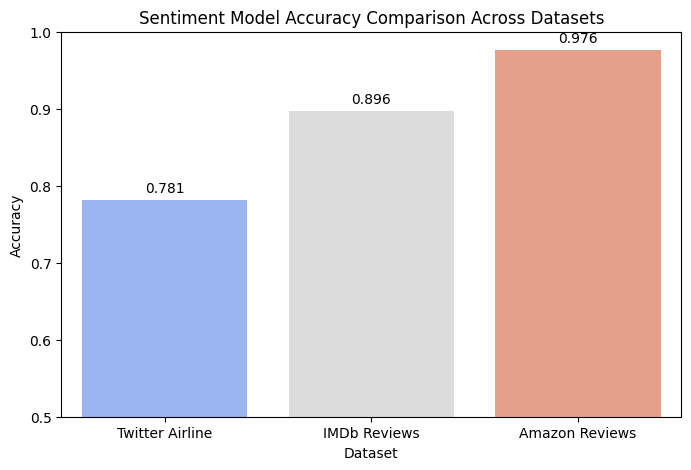

In [17]:
acc_dict = {
    'Twitter Airline': acc_twitter,
    'IMDb Reviews': acc_imdb,
    'Amazon Reviews': acc_amazon
}

plt.figure(figsize=(8,5))
sns.barplot(x=list(acc_dict.keys()), y=list(acc_dict.values()), palette='coolwarm')
plt.title("Sentiment Model Accuracy Comparison Across Datasets")
plt.ylabel("Accuracy")
plt.xlabel("Dataset")
plt.ylim(0.5, 1)
for i, v in enumerate(acc_dict.values()):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.show()


In [18]:
save_dir = '/content/drive/MyDrive/sentiment_triple_project'
os.makedirs(save_dir, exist_ok=True)

joblib.dump(vec_twitter, f'{save_dir}/twitter_vectorizer.joblib')
joblib.dump(ens_twitter, f'{save_dir}/twitter_ensemble.joblib')
joblib.dump(vec_imdb, f'{save_dir}/imdb_vectorizer.joblib')
joblib.dump(ens_imdb, f'{save_dir}/imdb_ensemble.joblib')
joblib.dump(vec_amazon, f'{save_dir}/amazon_vectorizer.joblib')
joblib.dump(ens_amazon, f'{save_dir}/amazon_ensemble.joblib')

print("✅ All three models and vectorizers saved successfully to Google Drive!")


✅ All three models and vectorizers saved successfully to Google Drive!
